# Brick Model Fault Detection & Visualization

Run all Brick-mapped rules on AHU7 data, then **zoom in on fault events** to inspect them. This notebook sets up the next tutorial: **working with false positives**.

## Workflow
1. Load Brick TTL, resolve column map, run rules (same as `run_all_rules_brick.py`)
2. Extract fault *events* (contiguous fault regions)
3. Randomly sample events and zoom in with plots
4. Inspect signals during fault windows — ready for false-positive analysis

## 1. Run Brick-driven fault detection

In [41]:
import sys
import time
from pathlib import Path

import pandas as pd
import numpy as np

start_time = time.time()

# Paths: run from project root, examples/, or examples/brick_fault_viz/
cwd = Path(".").resolve()
if (cwd / "examples" / "data_model.ttl").exists():
    EXAMPLES = cwd / "examples"
    ROOT = cwd
elif (cwd / "data_model.ttl").exists():
    EXAMPLES = cwd
    ROOT = cwd.parent
else:
    EXAMPLES = cwd.parent  # notebook in examples/brick_fault_viz/
    ROOT = EXAMPLES.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from open_fdd.engine.brick_resolver import (
    resolve_from_ttl,
    get_equipment_types_from_ttl,
)
from open_fdd.engine.runner import RuleRunner, load_rules_from_dir

In [42]:
def _filter_rules_by_equipment(rules, equipment_types):
    if not equipment_types:
        return rules
    return [
        r
        for r in rules
        if not r.get("equipment_type")
        or any(et in equipment_types for et in r.get("equipment_type", []))
    ]


def _add_synthetic_columns(df, column_map):
    df = df.copy()
    for brick_key, csv_col in column_map.items():
        if csv_col not in df.columns and (
            "Setpoint" in brick_key or "setpoint" in brick_key.lower()
        ):
            df[csv_col] = 0.5
    return df

In [43]:
ttl_path = EXAMPLES / "data_model.ttl"
rules_dir = EXAMPLES / "my_rules"
csv_path = EXAMPLES / "data_ahu7.csv"

column_map = resolve_from_ttl(ttl_path)
equipment_types = get_equipment_types_from_ttl(ttl_path)
print(f"Column map: {len(column_map)} mappings | Equipment: {equipment_types}")

all_rules = load_rules_from_dir(rules_dir)
rules = _filter_rules_by_equipment(all_rules, equipment_types)
print(f"Rules: {len(rules)} apply to this equipment")

df = pd.read_csv(csv_path)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = _add_synthetic_columns(df, column_map)

runner = RuleRunner(rules=rules)
result = runner.run(
    df,
    timestamp_col="timestamp",
    params={"units": "imperial"},
    skip_missing_columns=True,
    column_map=column_map,
)

flag_cols = [c for c in result.columns if c.endswith("_flag")]
print(f"\nFlag columns: {flag_cols}")
for col in flag_cols:
    print(f"  {col}: {int(result[col].sum())} fault samples")

Column map: 22 mappings | Equipment: ['VAV_AHU']
Rules: 6 apply to this equipment

Flag columns: ['fc1_flag', 'fc2_flag', 'fc3_flag', 'fc4_flag', 'bad_sensor_flag', 'flatline_flag']
  fc1_flag: 409 fault samples
  fc2_flag: 1826 fault samples
  fc3_flag: 31 fault samples
  fc4_flag: 717 fault samples
  bad_sensor_flag: 3146 fault samples
  flatline_flag: 3926 fault samples


## 2. Extract fault events (contiguous regions)

Each fault flag is a boolean series. An *event* is a contiguous run of `True` values.

In [44]:
from open_fdd.reports import get_fault_events, all_fault_events

In [45]:
events = all_fault_events(result, flag_cols)
print(f"Total fault events: {len(events)}")
for col in flag_cols:
    n = len([e for e in events if e[2] == col])
    print(f"  {col}: {n} events")

Total fault events: 611
  fc1_flag: 243 events
  fc2_flag: 79 events
  fc3_flag: 31 events
  fc4_flag: 44 events
  bad_sensor_flag: 138 events
  flatline_flag: 76 events


## 3. Zoom in on random fault events

Pick random events and plot the time window around them. Signals + fault shading.

In [46]:
from open_fdd.reports import build_rule_sensor_mapping

rule_to_sensors, rule_by_flag = build_rule_sensor_mapping(rules, result, column_map)

In [47]:
# zoom_on_event uses sensible defaults if rule has no sensors

In [48]:
import matplotlib.pyplot as plt
from open_fdd.reports import zoom_on_event

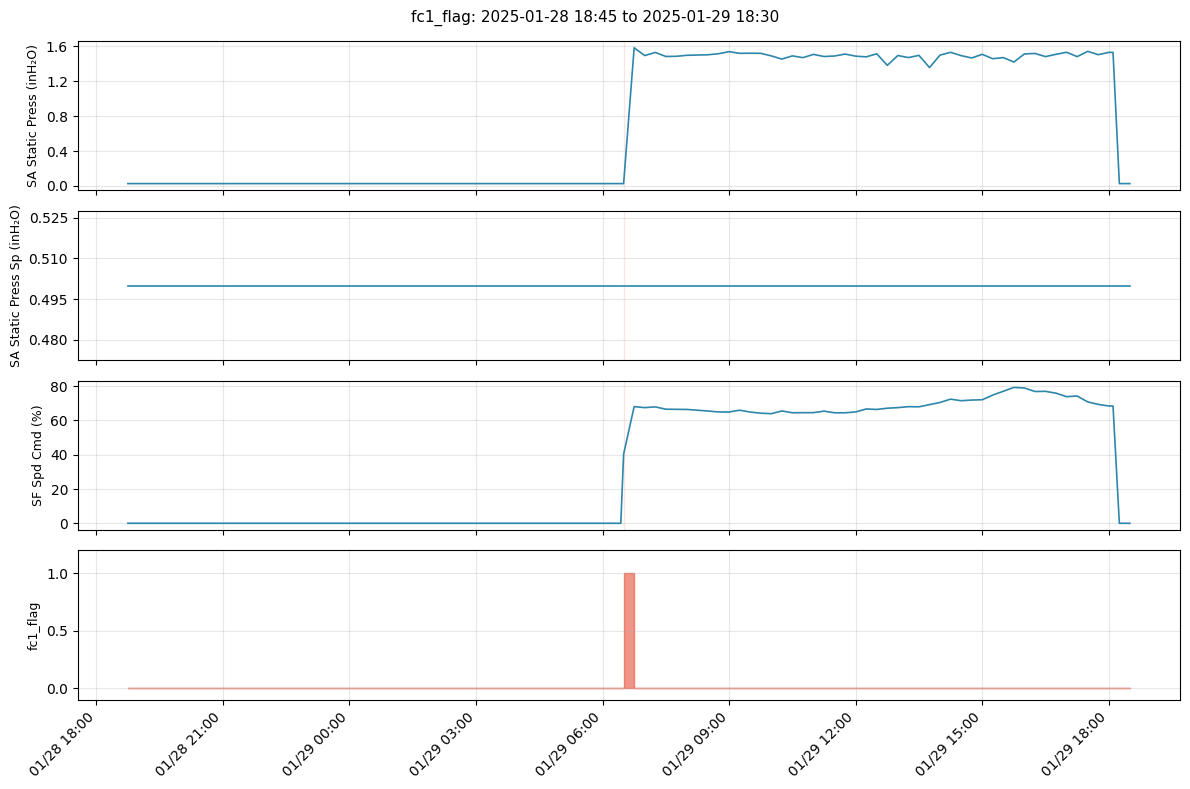

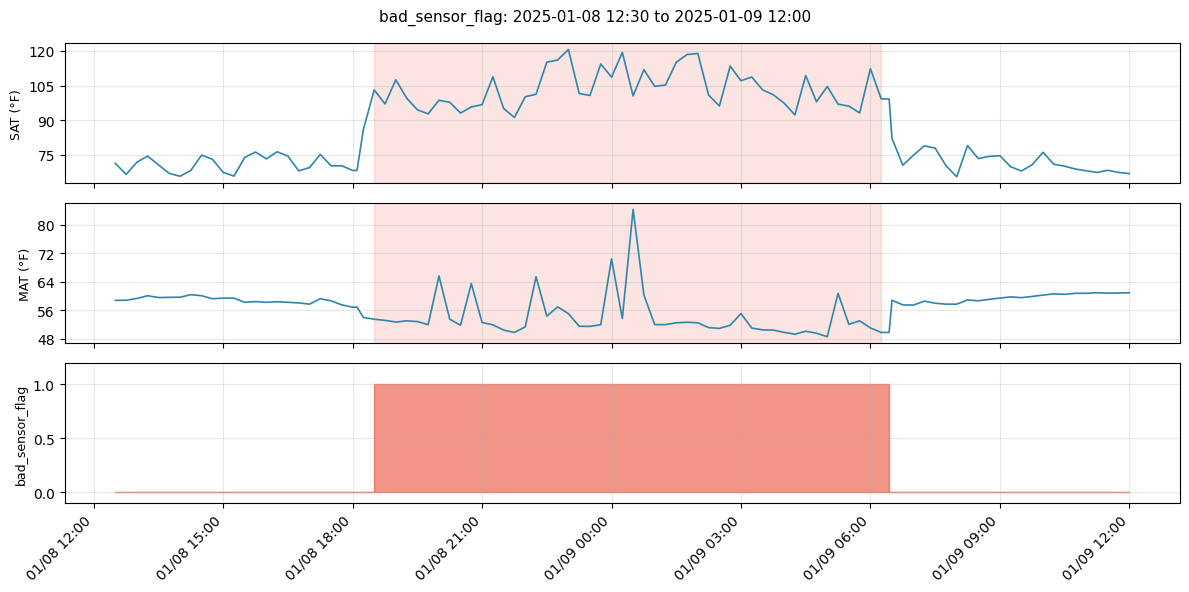

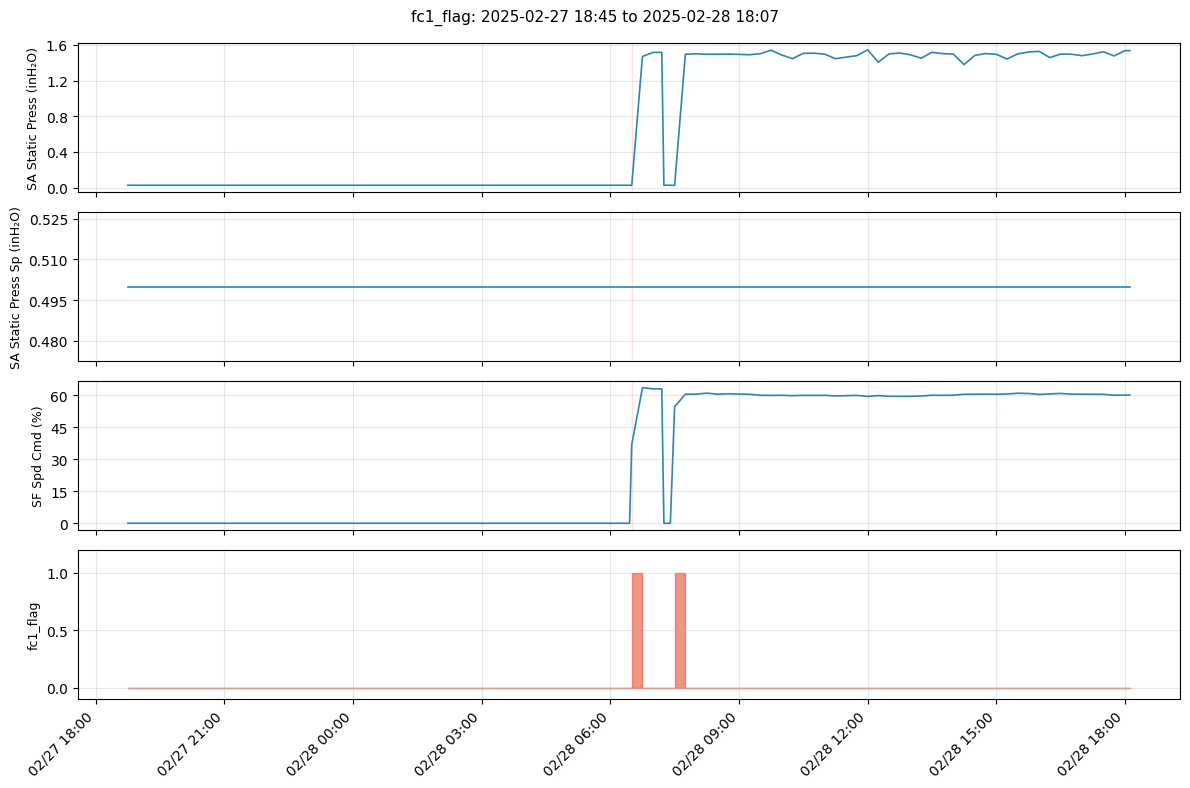

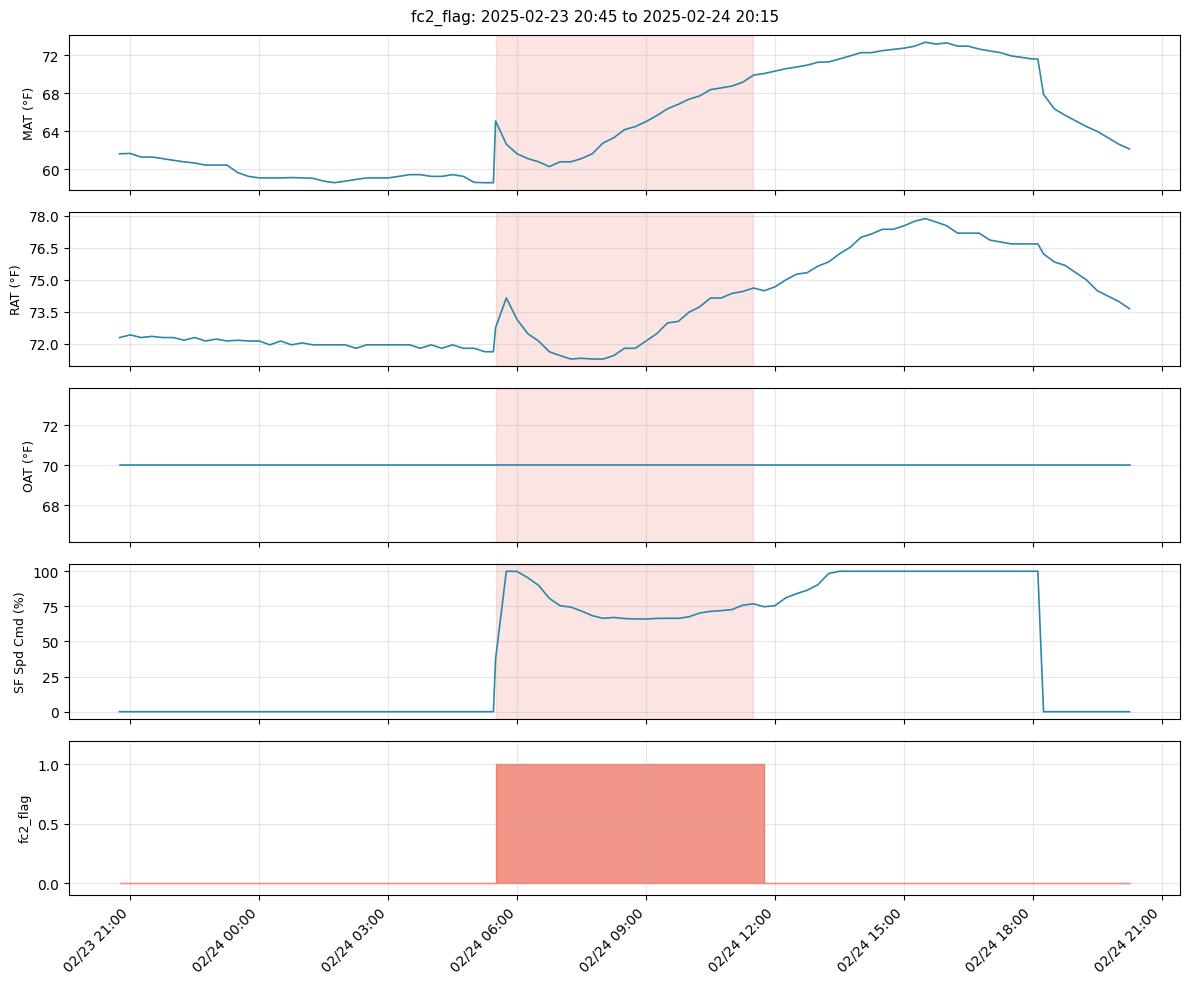

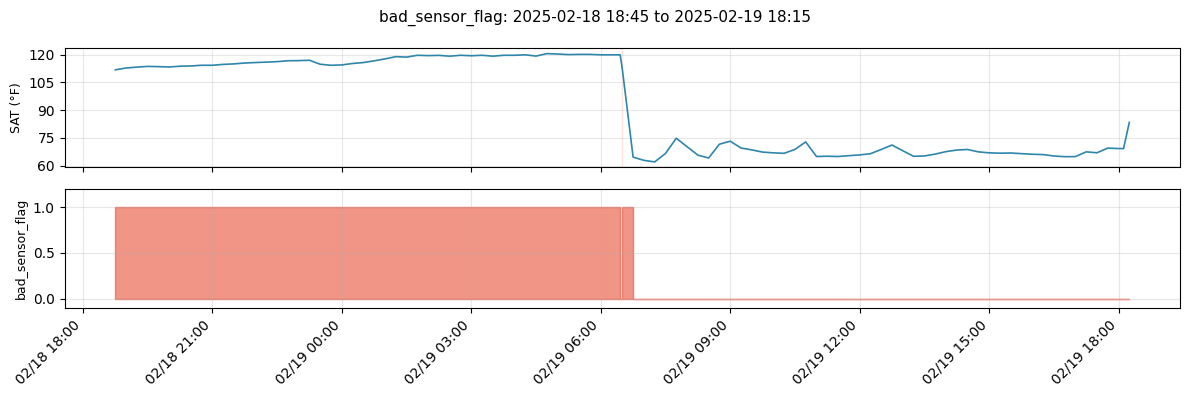

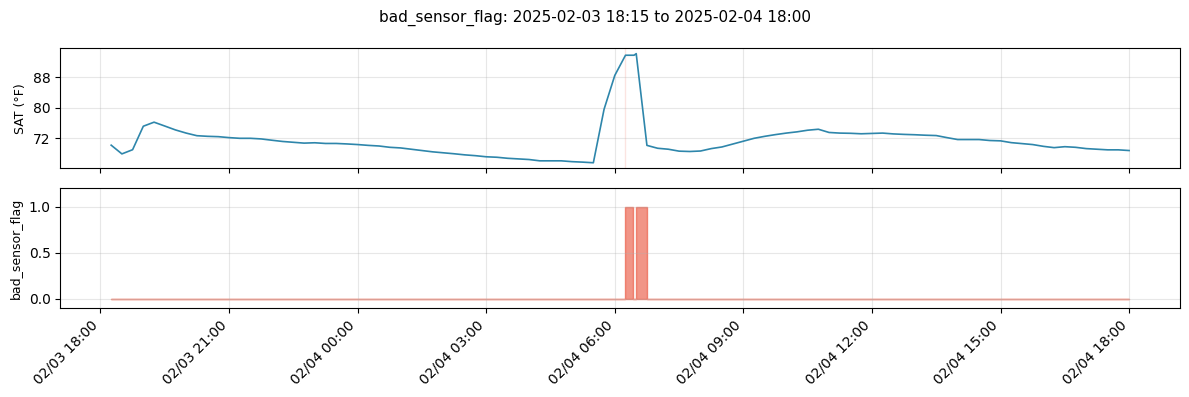

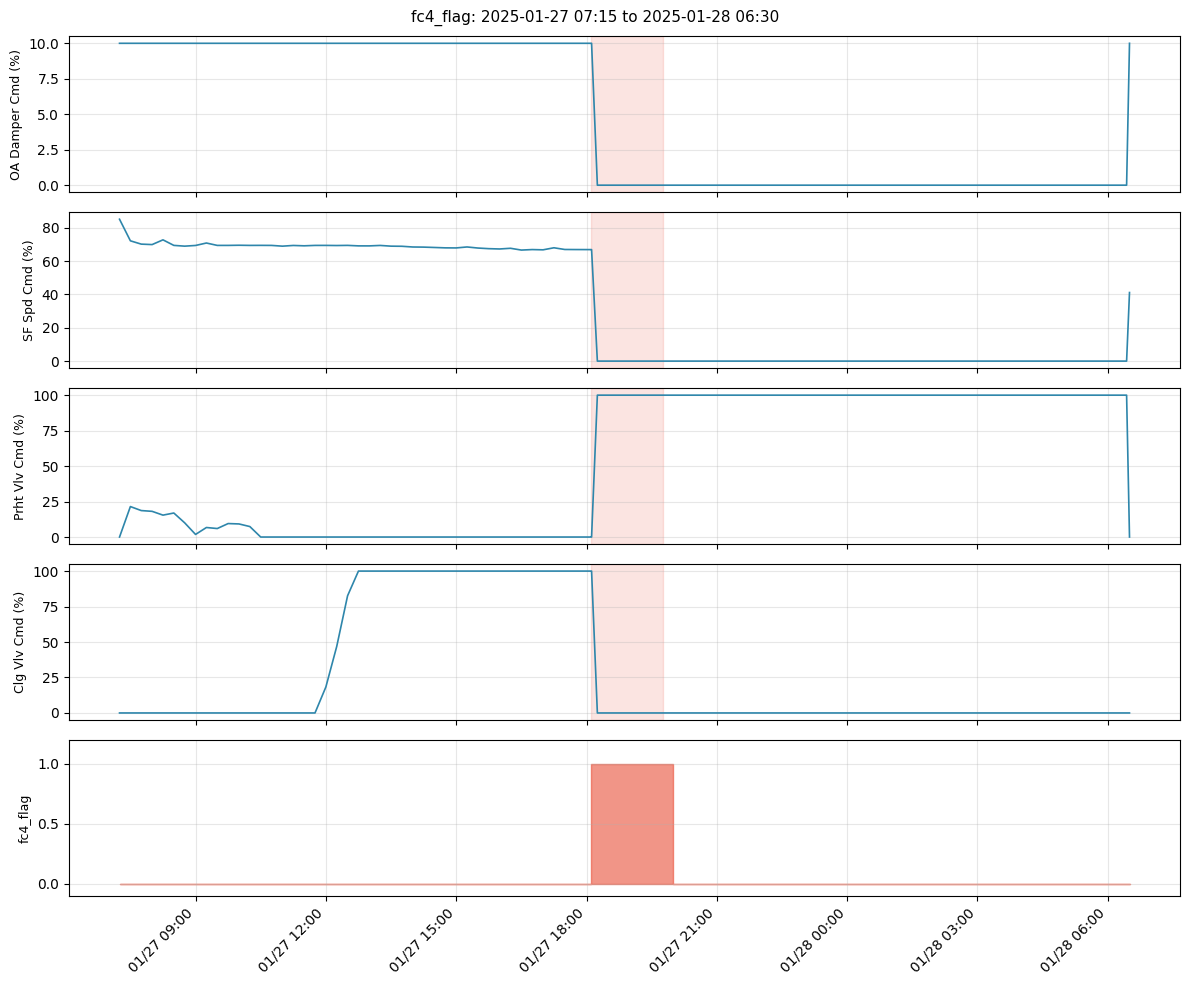

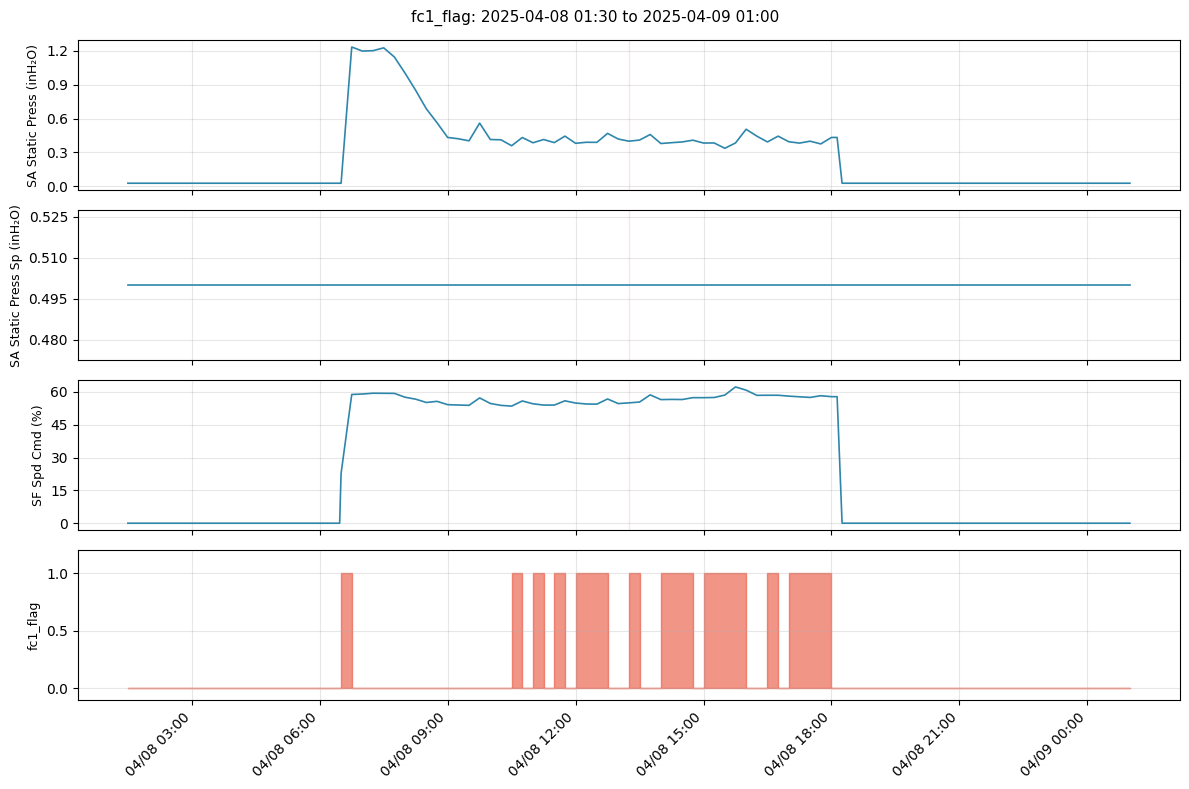

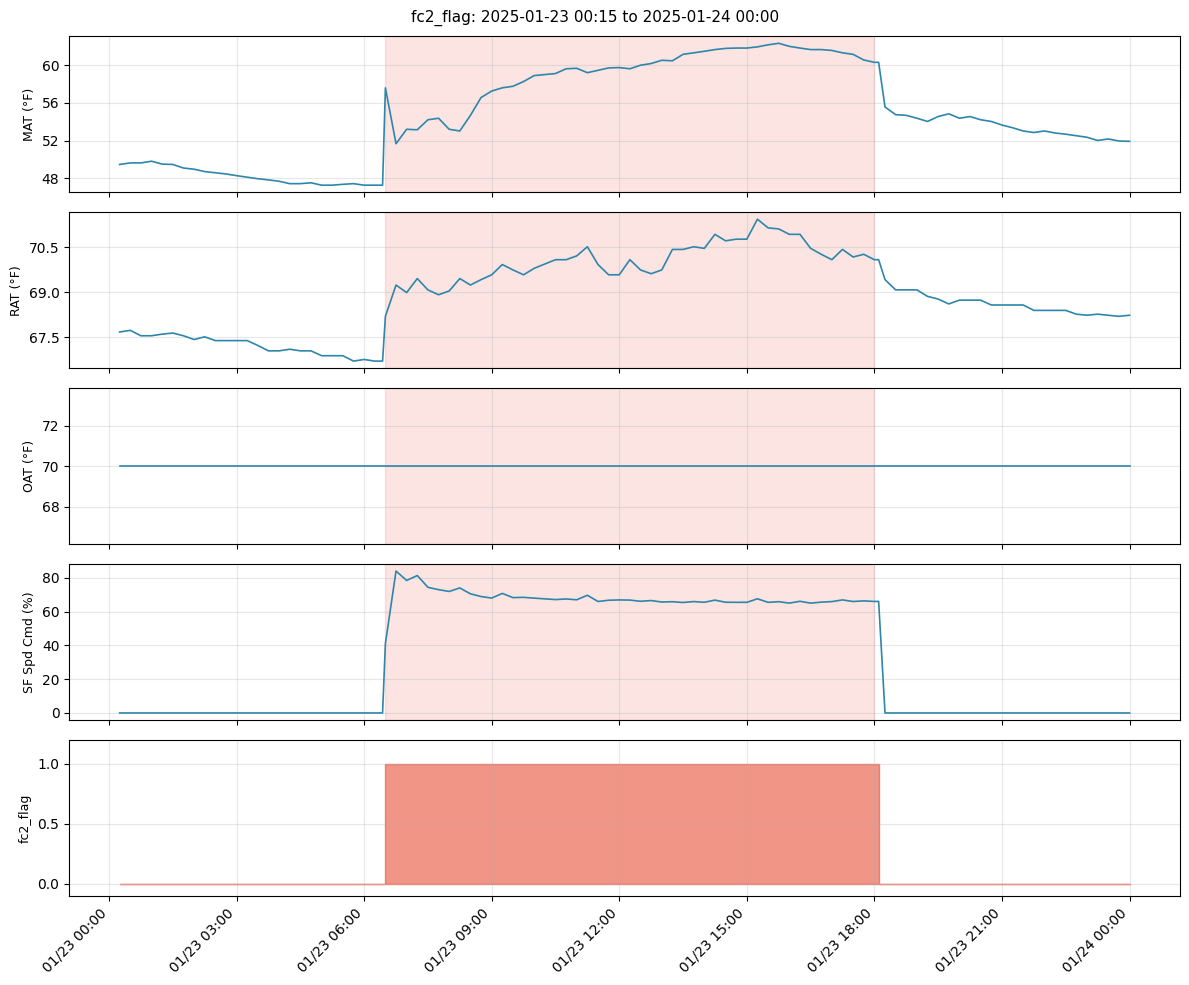

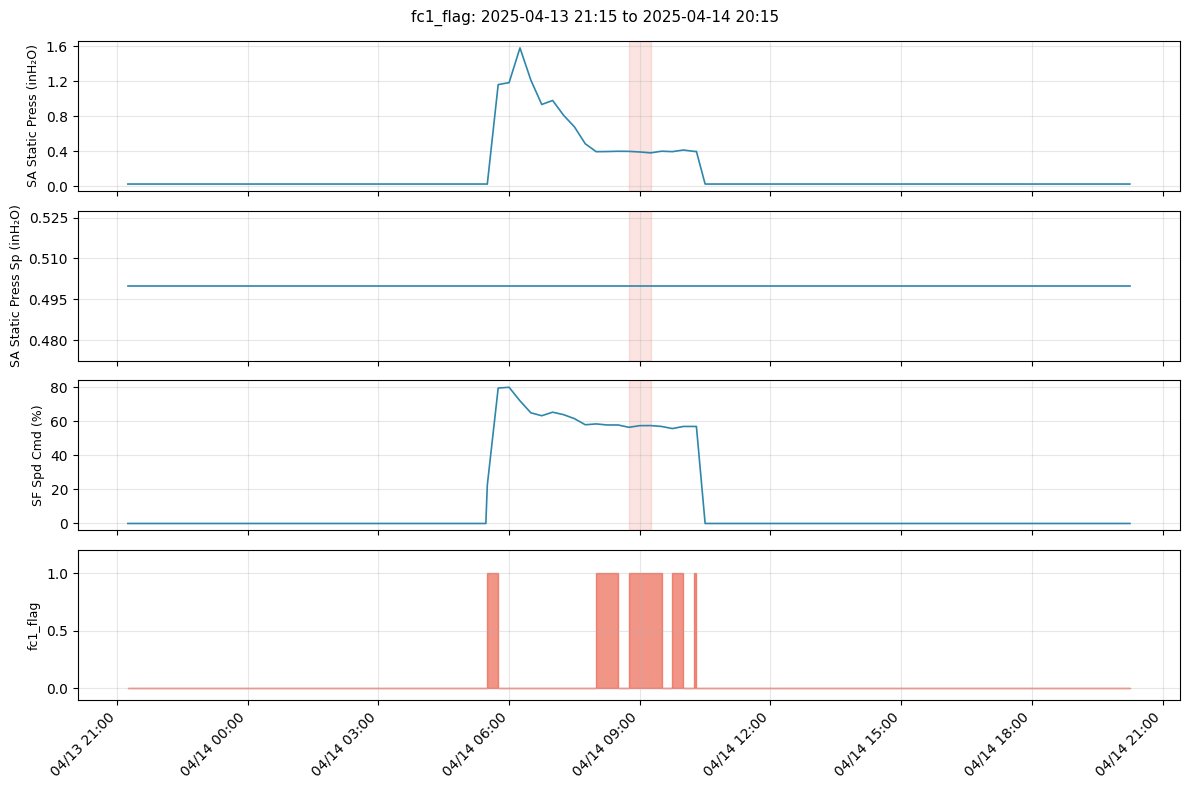

In [49]:
import random

random.seed(42)
n_sample = 10  # number of random events to plot
sampled = random.sample(events, min(n_sample, len(events)))

for event in sampled:
    zoom_on_event(
        result,
        event,
        pad=48,
        rule_to_sensors=rule_to_sensors,
        rule_by_flag=rule_by_flag,
        column_map=column_map,
    )
    plt.show()

## 4. Event summary table

Quick lookup: when did each fault type occur?

In [50]:
event_rows = []
for start_iloc, end_iloc, flag_name in events[:50]:  # first 50
    t0 = (
        result.iloc[start_iloc]["timestamp"]
        if "timestamp" in result.columns
        else start_iloc
    )
    t1 = (
        result.iloc[end_iloc]["timestamp"]
        if "timestamp" in result.columns
        else end_iloc
    )
    duration = end_iloc - start_iloc + 1
    event_rows.append(
        {"flag": flag_name, "start": t0, "end": t1, "duration_samples": duration}
    )

pd.DataFrame(event_rows)

,flag,start,end,duration_samples
0,flatline_flag,2025-01-01 06:00:00,2025-01-01 06:15:00,2
1,fc4_flag,2025-01-01 18:06:00,2025-01-01 21:00:00,13
2,fc1_flag,2025-01-02 06:30:00,2025-01-02 06:30:00,1
3,fc3_flag,2025-01-02 06:30:00,2025-01-02 06:30:00,1
4,bad_sensor_flag,2025-01-02 06:30:00,2025-01-02 06:30:00,1
5,fc4_flag,2025-01-02 14:15:00,2025-01-03 03:15:00,53
6,bad_sensor_flag,2025-01-03 01:30:00,2025-01-03 05:30:00,17
7,fc1_flag,2025-01-03 06:30:00,2025-01-03 06:30:00,1
8,fc3_flag,2025-01-03 06:30:00,2025-01-03 06:30:00,1
9,bad_sensor_flag,2025-01-03 06:30:00,2025-01-03 06:30:00,1


## 5. Fault analytics & histograms

Per-flag analytics (like the flatline tutorial): total hours, percent true, motor runtime, and **flag_true_*** (mean sensor value when fault is active). Plus histograms: fault sample counts and event duration distribution.

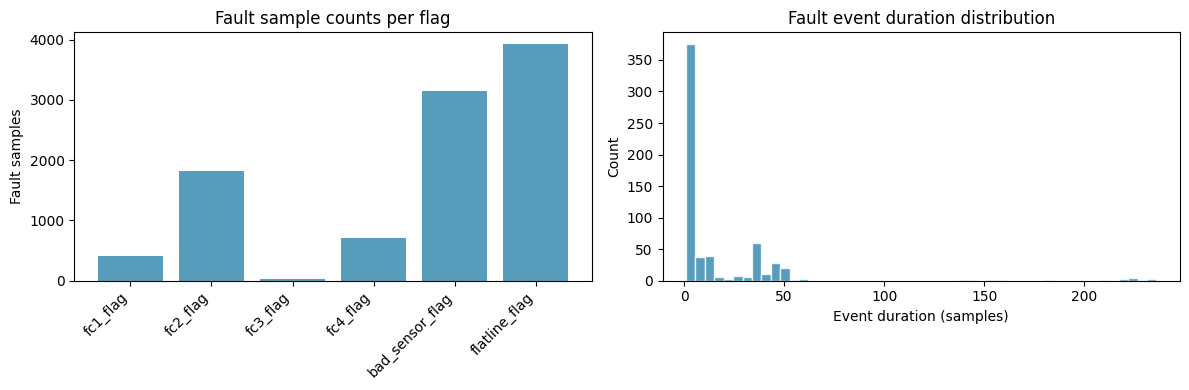

In [51]:
from open_fdd.reports import run_fault_analytics, plot_fault_analytics

summaries = run_fault_analytics(result, flag_cols, rules, column_map)
plot_fault_analytics(result, flag_cols, events, summaries)

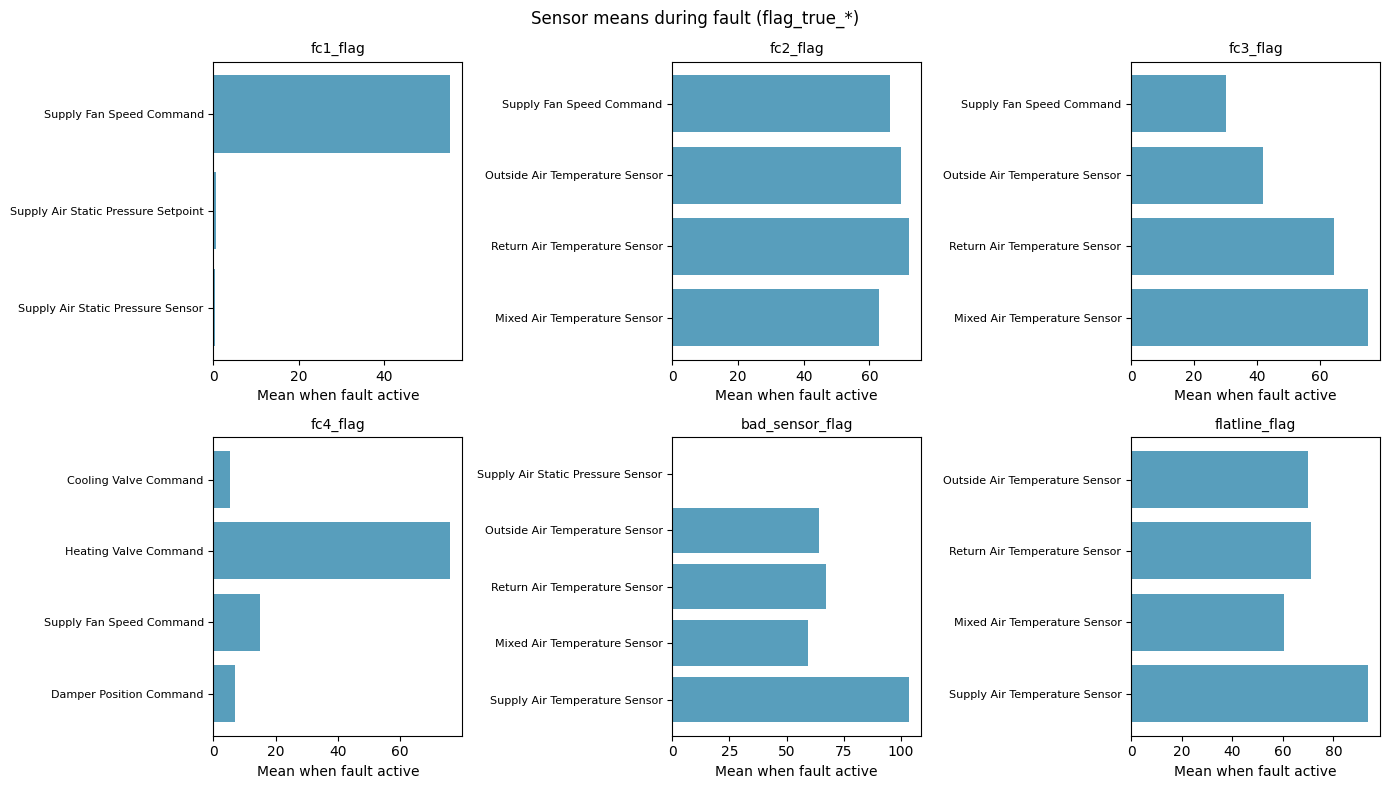

In [52]:
from open_fdd.reports import plot_flag_true_bars

plot_flag_true_bars(summaries, flag_cols)

In [53]:
# Print analytics summary (like flat_line_sensor_tuntorial)
from open_fdd.reports import print_summary

for fc in flag_cols:
    title = fc.replace("_flag", " fault")
    print_summary(summaries[fc], title=title)


--- fc1 fault ---
  total days: 105.39
  total hours: 2529
  hours fc1 mode: 88
  percent true: 4.0
  percent false: 96.0
  percent hours true: 3.47
  hours motor runtime: 860.3
  flag true Supply Air Static Pressure Sensor: 0.3
  flag true Supply Air Static Pressure Setpoint: 0.5
  flag true Supply Fan Speed Command: 55.71
  fault period start: 2025-01-02 06:30:00
  fault period end: 2025-04-14 10:15:00
  fault period days: 102.16
  fault period hours: 2452
  fault period rows: 9900
  fault period rows flagged: 409
  fault period percent true: 4.13

--- fc2 fault ---
  total days: 105.39
  total hours: 2529
  hours fc2 mode: 455
  percent true: 17.88
  percent false: 82.12
  percent hours true: 17.97
  hours motor runtime: 860.3
  flag true Mixed Air Temperature Sensor: 62.99
  flag true Return Air Temperature Sensor: 72.15
  flag true Outside Air Temperature Sensor: 69.61
  flag true Supply Fan Speed Command: 66.38
  fault period start: 2025-01-08 15:30:00
  fault period end: 2025-0

In [54]:
# Total notebook run time
elapsed = time.time() - start_time
hours, remainder = divmod(int(elapsed), 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Notebook run time: {hours}h {minutes}m {seconds}s")

Notebook run time: 0h 0m 5s


## Next: False positives & AI-assisted workflows

Many fault flags can be **false positives** — the rule fired but the condition was acceptable (e.g. startup, setpoint change, sensor noise).

**See [AI-Assisted FDD Roadmap](../../docs/ai_assisted_fdd_roadmap.md)** for:
- Agentic workflows to sift through hundreds of events
- False positive tuning and root cause analysis
- Best practices for AI-assisted diagnostics (Cursor, Claude, GPT)